In [9]:
# Install necessary packages for the project

%pip install transformers pandas scikit-learn matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [10]:
# import necessary libraries and load the dataset
import pandas as pd


df = pd.read_csv('college_feedbacks.csv')
# print the first few rows of the dataframe to verify, where the dataset is expected to have columns like 'feedback', 'rating', etc.
df.head()


,feedback_id,feedback_text,category,department,rating,semester,student_type
0,1,Physics professors explain complex topics clea...,Academics,Physics,3,Fall 2023,Undergraduate
1,2,New dorm buildings have great amenities but th...,Facilities,Housing,4,Spring 2024,Freshman
2,3,Financial aid office takes 3+ weeks to respond...,Administration,Financial Aid,1,Fall 2023,Transfer
3,4,International student orientation helped me se...,Student Life,International Programs,5,Spring 2024,International
4,5,Chemistry lab safety protocols are extremely t...,Academics,Chemistry,5,Fall 2023,Graduate


In [11]:
# import necessary libraries for model
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

# load pre-trained model from google i.e., Flan-T5 and tokenizer from transformers library
model_name = 'google/flan-t5-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


In [12]:
# The function will creat a few shot prompt for the model

def create_prompt(feedback):
    return f"""You are an assistant that classifies student feedback into one of the following categories:

Facilities  
Academics  
Administration  
Student Life

Only classify the feedback based on the main theme. Do not provide any additional information or explanations.

Classify based on the main theme. Some examples:

Feedback: "The library is always crowded and lacks enough seating."
Category: Facilities

Feedback: "Wi-Fi in the hostel doesn't work half the time."  
Category: Facilities

Feedback: "The professors are very knowledgeable but the lectures are too fast-paced."
Category: Academics

Feedback: "The lectures are too rushed and we barely understand the core concepts."  
Category: Academics

Feedback: "I feel overwhelmed and there's no proper counseling support."  
Category: Student Life

Feedback: "The placement cell is very active and helps students a lot."
Category: Administration

Now classify the following:

Feedback: "{feedback}"  
Category:"""


In [13]:
# Function to classify feedback using the model

def classify_feedback(feedback_text):
    prompt = create_prompt(feedback_text)
    input_ids = tokenizer(prompt, return_tensors="pt" ).input_ids
    output_ids = model.generate(input_ids, max_length=10)
    result = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return result.strip()

In [14]:
# Example usage
print(classify_feedback("The mentorship program is very helpful for career guidance."))
print(classify_feedback("Hostel food quality has improved but still needs work."))
print(classify_feedback("The admin is slow in responding to our queries."))
print(classify_feedback("The club activities are too hectic and not well organized, taking too much time away from studies."))


Student Life
Facility
Administration
Student Life


In [15]:
# test the dataset with the model to classify feedbacks

def test_dataset():
    
    predictions = []
    for feedback in df['feedback_text']:
        category = classify_feedback(feedback)
        predictions.append(category)

    df['predicted_category'] = predictions

    df.to_csv("tested_feedbacks.csv", index=False)
    print("Saved classified feedback to tested_feedbacks.csv")

test_dataset()

print()
pd.read_csv("tested_feedbacks.csv").head()


Saved classified feedback to tested_feedbacks.csv



,feedback_id,feedback_text,category,department,rating,semester,student_type,predicted_category
0,1,Physics professors explain complex topics clea...,Academics,Physics,3,Fall 2023,Undergraduate,Academics
1,2,New dorm buildings have great amenities but th...,Facilities,Housing,4,Spring 2024,Freshman,Facilities
2,3,Financial aid office takes 3+ weeks to respond...,Administration,Financial Aid,1,Fall 2023,Transfer,Administration
3,4,International student orientation helped me se...,Student Life,International Programs,5,Spring 2024,International,Student Life
4,5,Chemistry lab safety protocols are extremely t...,Academics,Chemistry,5,Fall 2023,Graduate,Administration


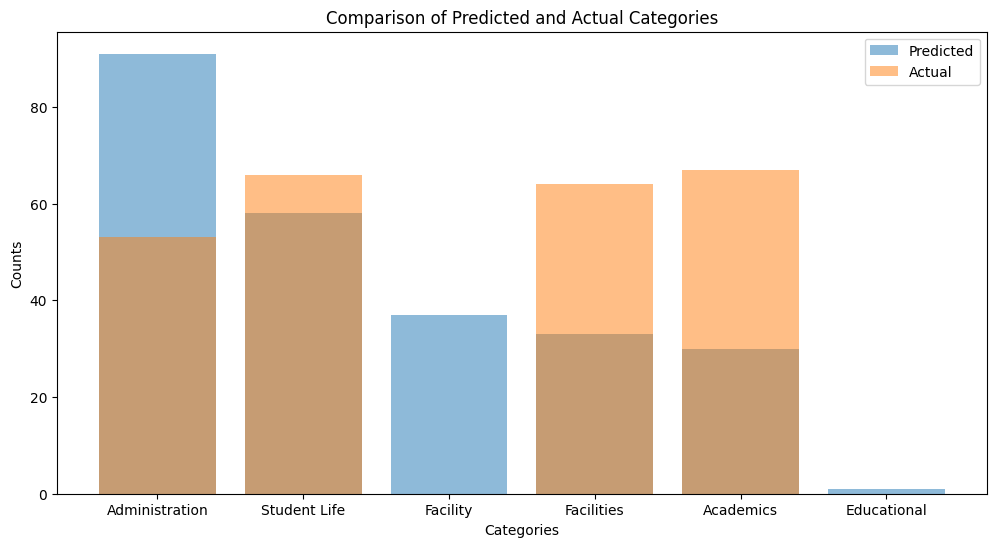

In [16]:

# visualization of the results using matplotlib
import matplotlib.pyplot as plt
# compare the predicted categories with the actual categories
def compare_categories():
    category_counts = df['predicted_category'].value_counts()
    actual_counts = df['category'].value_counts()
    plt.figure(figsize=(12, 6))
    plt.bar(category_counts.index, category_counts.values, alpha=0.5, label='Predicted')
    plt.bar(actual_counts.index, actual_counts.values, alpha=0.5, label='Actual')
    plt.xlabel('Categories')
    plt.ylabel('Counts')
    plt.title('Comparison of Predicted and Actual Categories')
    plt.legend()
    plt.show()

compare_categories()

In [17]:
# classification report to evaluate the model's performance
from sklearn.metrics import classification_report
def evaluate_model():
    print("Classification Report:")
    print(classification_report(df['category'], df['predicted_category']))

evaluate_model()

Classification Report:
                precision    recall  f1-score   support

     Academics       0.80      0.36      0.49        67
Administration       0.47      0.81      0.60        53
   Educational       0.00      0.00      0.00         0
    Facilities       0.85      0.44      0.58        64
      Facility       0.00      0.00      0.00         0
  Student Life       0.76      0.67      0.71        66

      accuracy                           0.56       250
     macro avg       0.48      0.38      0.40       250
  weighted avg       0.73      0.56      0.59       250



C:\Users\satya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\satya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\satya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1565: Unde

In [18]:
# export the json
import json
def export_to_json():
    result = df[['feedback_text', 'predicted_category']].to_dict(orient='records')
    with open('json_tested_feedbacks.json', 'w') as f:
        json.dump(result, f, indent=4)
    print("Exported classified feedbacks to json_test_feedbacks.json")

export_to_json()

Exported classified feedbacks to json_test_feedbacks.json
